# Neural network classification

In this notebook, we will be train neural network classifiers using the `MLPClassifier` class from `sklearn.neural_network` module. We will cover two cases, each using different optimization algorithms: 

1. L-BFGS: Deterministic optimization algorithm for small to medium datasets
2. Adam: Stochastic gradient optimization algorithm for large datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier

%matplotlib inline
plt.rcParams.update(**{
    'figure.dpi':150
})

## Binary classification on the fgl data

For the demo, we will train  a neural network classifier on a binary version of the `FGL` dataset discussed in the lectures.

In [2]:
fgl = pd.read_table('../data/fgl.txt',sep='\t')
fgl

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type
1,3.01,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,WinF
2,-0.39,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,WinF
3,-1.82,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,WinF
4,-0.34,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,WinF
5,-0.58,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,WinF
...,...,...,...,...,...,...,...,...,...,...
210,-1.77,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,Head
211,-1.15,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,Head
212,2.65,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,Head
213,-1.49,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,Head


As in the lectures, we will convert the response `type` to binary (whether type is windowed or not). We will also standardize the predictors

In [3]:
# response - whether type is windowed or not
y = 1*(fgl['type'].isin(['WinNF','WinF'])).values
pd.Series(y).value_counts()

1    146
0     68
dtype: int64

In [4]:
# extract and standardize predictors
columns = [col for col in fgl.columns if col != 'type']
X = fgl[columns].values
X_mean,X_std = X.mean(axis=0),X.std(axis=0)
X = (X-X_mean)/X_std

Syntax for the `MLPClassifier` is the same as the regression case. 

In [6]:
# define a neural network model
np.random.seed(456)

# define a neural network classifer
clf1 = MLPClassifier(
    hidden_layer_sizes=5, # scalar -> single hidden layer with 10 units
    activation='logistic', # activation function for the hidden layer
    solver='lbfgs', # deterministic optimizer (not the default)
    alpha=1,# regularization parameter
    max_iter = 1000 # number of LBFGS steps
)

# fit model
_ = clf1.fit(X,y)

`MLPClassifier` (and many other classifiers in scikit-learn) have two prediction methods:
- `.predict_proba`: returns class probabilities
- `.predict`: returns the class with the highest probability. For binary classification, the threshold is automatically 0.5

In [7]:
# .predict_proba returns the class probabilities
p_hat = clf1.predict_proba(X)
with np.printoptions(formatter={'float':lambda x: '%6.3f'%x},linewidth=100):
    print(p_hat[[0,1,-1,61,84,108,127],:])

[[ 0.096  0.904]
 [ 0.153  0.847]
 [ 0.972  0.028]
 [ 0.372  0.628]
 [ 0.575  0.425]
 [ 0.581  0.419]
 [ 0.322  0.678]]


In [10]:
p_hat = clf1.predict_proba(X)[:,1]
1*(p_hat<0.4)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [8]:
# .predict returns the class with the highest probability
y_hat = clf1.predict(X)
y_hat[[0,1,-1,61,84,108,127]]

array([1, 1, 0, 1, 0, 0, 1])

### Tuning hyperparameters

Since there are only a little over 200 observations, we will be using replicated 5-fold CV. We will compare different hyperparameter configurations using prediction accuracy.

In [11]:
from sklearn.model_selection import RepeatedKFold,GridSearchCV

In [12]:
np.random.seed(3)
nn_clf_final = GridSearchCV(
    estimator = MLPClassifier(
        hidden_layer_sizes=5,
        activation='logistic',
        solver='lbfgs', 
        alpha=1,
        max_iter = 1000 
    ),
    param_grid = { # dictionary containing possible values of each hyperparameter
        'alpha':[1e-2,1e-1,1],
        'hidden_layer_sizes':[5,10,20]
    },
    scoring='accuracy', # scoring metric - prediction accuracy
    refit=True,
    cv = RepeatedKFold(n_splits=5,n_repeats=5), # 5 replicates of 5-fold CV
).fit(X,y)

print('Best parameters')
print(nn_clf_final.best_params_)

print('Best CV accuracy: %.3f'%nn_clf_final.best_score_)

Best parameters
{'alpha': 1, 'hidden_layer_sizes': 20}
Best CV accuracy: 0.854


### Important predictors via ALEPlots


For the ALE plots, we will be using log-odds as the predictive function.

$$
\text{log-odds}(\mathbf{x}) = \log\left(\frac{p(\mathbf{x})}{1-p(\mathbf{x})}\right)
$$

For logistic regression models, the log-odds function is linear in the predictors.
$$
\text{log-odds}(\mathbf{x}) = \beta_0 + \beta^T\mathbf{x}
$$

In [13]:
from ale_utils import first_order_aleplot_quant # first order ALE plots
from functools import partial

def log_odds(X,model):
    '''
    Function that returns the log-odds from a binary classifer 
    implementing scikit-learn like API for computing class 
    probabilities
    '''
    p_hat = model.predict_proba(X)[:,1]
    return np.log(p_hat)-np.log(1-p_hat)

# function with the model argument fixed
log_odds_nnet = partial(log_odds,model=nn_clf_final)

In [14]:
# alepython requires a dataframe
X_dat = pd.DataFrame(X,columns=columns)
X_dat

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,0.872868,0.284953,1.254639,-0.692442,-1.127082,-0.671705,-0.145766,-0.352877,-0.586451
1,-0.249333,0.591817,0.636168,-0.170460,0.102319,-0.026213,-0.793734,-0.352877,-0.586451
2,-0.721318,0.149933,0.601422,0.190912,0.438787,-0.164533,-0.828949,-0.352877,-0.586451
3,-0.232831,-0.242853,0.698710,-0.310994,-0.052974,0.112107,-0.519052,-0.352877,-0.586451
4,-0.312045,-0.169205,0.650066,-0.411375,0.555256,0.081369,-0.624699,-0.352877,-0.586451
...,...,...,...,...,...,...,...,...,...
209,-0.704815,0.898681,-1.865511,2.881125,-0.052974,-0.640968,0.157088,1.783978,-0.586451
210,-0.500178,1.856097,-1.865511,1.094342,0.529374,-0.763919,-0.392276,2.852405,-0.586451
211,0.754046,1.168721,-1.865511,1.154570,0.995252,-0.763919,-0.364103,2.953200,-0.586451
212,-0.612399,1.193270,-1.865511,0.993960,1.241133,-0.763919,-0.335931,2.812087,-0.586451


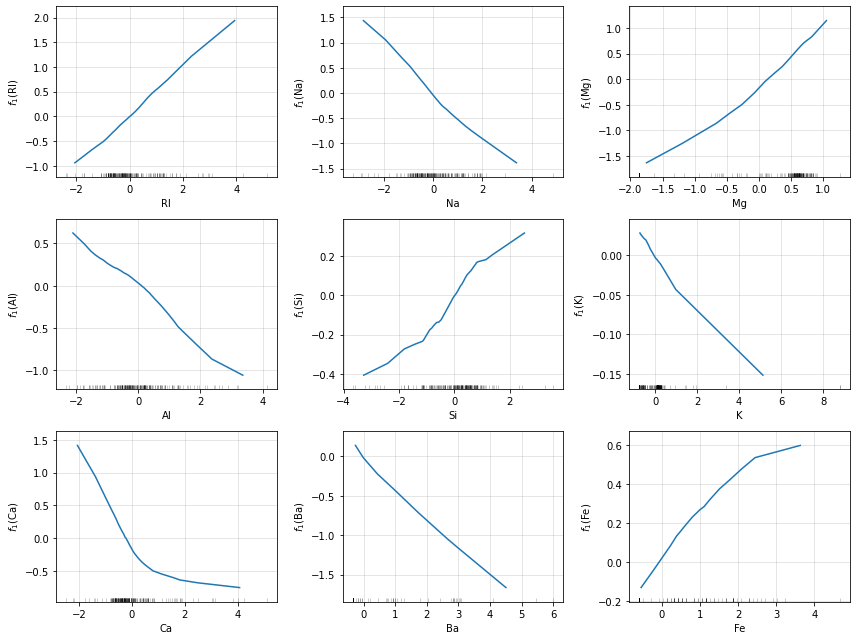

In [15]:
# 9 predictors, plotting in a 3x3 grid
num_rows=3
num_cols=3
fig,axs = plt.subplots(num_rows,num_cols,figsize=(12,9))
for i in range(num_rows):
    for j in range(num_cols):
        # select correct feature
        feature = X_dat.columns[num_cols*i + j]
        _ = first_order_aleplot_quant(log_odds_nnet,X_dat,feature,bins=50,ax=axs[i,j])

fig.tight_layout()

Three of the most important predictors - `RI`,`Na`, and `Mg` - have almost linear effects on the log-odds. For this problem, a logistic regression model can be competitive. 

**Exerise**: Compare the neural network model against a logistic regression model using cross-validation.

## Large-scale neural network classification

In this demo, we will fit a neural network model on the adult income dataset from class.

In [16]:
adult = pd.read_csv('../data/adult_train.csv')
adult

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


### Preprocessing features 


1. Drop redundant or irrelevant columns.
2. Standardize numerical features.
3. One hot encode categorical features

In [17]:
# drop two  of the columns
# education and education-num convey the same information
adult = adult.drop(['education','fnlwgt'],axis=1)

features = adult.drop('income',axis=1) 

# extract different types of columns
numerical_cols = ['age', 'education-num', 'capital-gain', 'capital-loss','hours-per-week']
cat_cols = [col for col in features.columns if col not in numerical_cols]

print('Numerical predictors:')
print(numerical_cols)
print()
print('Categorical predictors:')
print(cat_cols)

Numerical predictors:
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Categorical predictors:
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [18]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [19]:
sc = StandardScaler().fit(features[numerical_cols])
X_num = sc.transform(features[numerical_cols])
X_num 

array([[ 0.03067056,  1.13473876,  0.1484529 , -0.21665953, -0.03542945],
       [ 0.83710898,  1.13473876, -0.14592048, -0.21665953, -2.22215312],
       [-0.04264203, -0.42005962, -0.14592048, -0.21665953, -0.03542945],
       ...,
       [ 1.42360965, -0.42005962, -0.14592048, -0.21665953, -0.03542945],
       [-1.21564337, -0.42005962, -0.14592048, -0.21665953, -1.65522476],
       [ 0.98373415, -0.42005962,  1.88842434, -0.21665953, -0.03542945]])

In [20]:
# one hot encode categorical columns
oe = OneHotEncoder(sparse=False).fit(features[cat_cols])
X_cat = oe.transform(features[cat_cols])
X_cat.shape

(32561, 86)

In [21]:
# concatenate columns
X = np.column_stack([X_num,X_cat])

# response - convert to 0/1 variable
y = 1*(adult['income']==' >50K').values
pd.Series(y).value_counts()

0    24720
1     7841
dtype: int64

###  A brief introduction to stochastic gradient methods for neural networks

When we ''fit" neural networks, we are solving an optimization problem in the parameters of neural networks to minimize some average loss function on the training data:
$$
E(\theta) = \frac{1}{n}\sum_{i=1}^{n} L(y_i, f(x_i;\theta))
$$

where 
- $\theta$ are the parameters of the neural network. 
- $f(\cdot;\cdot)$ is the output of the neural network, 
- $L(\cdot,\cdot)$ is the loss function (squared error for regression, logistic loss for classification),
- $n$ is the number of training observations.


In standard gradient based optimization methods, we compute the gradient of $E(\theta)$ with respect to $\theta$ in each iteration. This is expensive for large $n$. In stochastic gradient optimization methods, instead of using all the data points to compute this gradient, we use a random subset of points to approximate this gradient at each iteration. 

To be more specific, we first randomly divide the training data into (roughly) equal sized subsets (called batches). Let $n_b$ denote the number of observations in each batch - also known as **batch size**. At each iteration, we approximate the above loss function with 

$$
E^{(b)}(\theta) = \frac{1}{n_b}\sum_{i=1}^{n_b} L(y^{(b)}_i, f(x^{(b)}_i;\theta)),
$$

and compute the gradient of this objective instead.

An **epoch** is defined as one complete pass through the training set. Note that the number of epochs is *NOT* the same as the number of optimization iterations.

### Model fitting and tuning

In [22]:
from sklearn.base import clone
from sklearn.model_selection import KFold

In [25]:
# define a neural network model with stochastic optimizer
np.random.seed(456)
clf_init = MLPClassifier(
    ## archiecture hyperparameters ## 
    hidden_layer_sizes=20, # scalar -> single hidden layer with 20 units
    activation='logistic', # activation function for the hidden layer
    alpha=1e-4,# regularization parameter,
    solver='adam', # stochastic optimizer (default)
    learning_rate_init=0.01,# learning rate, controls the step size
    batch_size=512, # the number of samples considered in each iteration
    max_iter = 100, # number of epochs through the training set,
    early_stopping=True, # monitor validation_loss and stop if there is no improvement
    n_iter_no_change=10, # if validation loss doesn't improve for 10 epochs, terminate optimization
    validation_fraction=0.1, # fraction of the dataset to set as aside as validation data
    verbose=True
)

# fit model
clf1 = clone(clf_init).fit(X,y)

Iteration 1, loss = 0.40845964
Validation score: 0.846792
Iteration 2, loss = 0.32792290
Validation score: 0.856617
Iteration 3, loss = 0.32147337
Validation score: 0.855081
Iteration 4, loss = 0.31854880
Validation score: 0.855695
Iteration 5, loss = 0.31658450
Validation score: 0.854467
Iteration 6, loss = 0.31520004
Validation score: 0.853239
Iteration 7, loss = 0.31322399
Validation score: 0.855081
Iteration 8, loss = 0.31166777
Validation score: 0.854467
Iteration 9, loss = 0.31068866
Validation score: 0.853239
Iteration 10, loss = 0.30985046
Validation score: 0.855388
Iteration 11, loss = 0.30757774
Validation score: 0.856924
Iteration 12, loss = 0.30644473
Validation score: 0.859687
Iteration 13, loss = 0.30556477
Validation score: 0.857231
Iteration 14, loss = 0.30530462
Validation score: 0.852932
Iteration 15, loss = 0.30477322
Validation score: 0.857231
Iteration 16, loss = 0.30434049
Validation score: 0.858766
Iteration 17, loss = 0.30334888
Validation score: 0.854467
Iterat

In [26]:
np.random.seed(3)

# turn off the verbose flag
clf_init.set_params(**{'verbose':False})

clf_final = GridSearchCV(
    estimator = clf_init,
    param_grid = { # dictionary containing possible values of each hyperparameter
        'alpha':[1e-6,1e-4,1e-3],
        'hidden_layer_sizes':[5,10,20],
        'learning_rate_init':[1e-3,1e-2,1e-1]
    },
    scoring='accuracy', # scoring metric - prediction accuracy
    refit=True,
    cv = KFold(n_splits=5,shuffle=True), # 1 replicate of 5-fold CV
).fit(X,y)

/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [27]:
print('Best parameters')
print(clf_final.best_params_)

print('Best CV accuracy: %.3f'%clf_final.best_score_)

Best parameters
{'alpha': 0.0001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.1}
Best CV accuracy: 0.859


The values tried in grid search are not exhaustive. You can try larger values for the number of units in the hidden layer. 